*Scroll past code to see text content...*

# Code For Notebook

In [201]:
import msprime
import tskit
import numpy as np
import math
import random
from collections import defaultdict
from itertools import chain
import networkx as nx
import matplotlib.pyplot as plt    
import time


def identify_unique_paths(ts):
    """
    Finds all of the paths within the incomplete ARG, stored as a tskit tree sequence
    
    Input:
    - ts: tskit tree sequence
    
    Output:
    - all_paths: list, unique paths within the ARG
    """
    # make the (incomplete) ARG
    topology = defaultdict(list)
    for tree in ts.trees():
        for k, v in chain(tree.parent_dict.items()):
            if v not in topology[k]:
                topology[k].append(v)
    G = nx.DiGraph(dict(topology))

    #unique paths up the ARG
    gmrca = ts.node(ts.num_nodes-1).id
    all_paths = []
    for sample in ts.samples():
        paths = nx.all_simple_paths(G, source=sample, target=gmrca)
        all_paths.extend(paths)
    return all_paths

def create_sample_locations_array(paths, sample_locs):
    """
    Expands sample locations to pair with the unique paths. Accounts for samples having multiple
    paths.
    
    Inputs:
    - paths: list, unique paths within the ARG. Output of identify_unique_paths(). If not
        provided, this will be calculated
    - sample_locs: numpy array, sample locations
    
    Output:
    - path_locs: numpy array, sample locations expanded to match number of paths
    """
    sample_locs_array = []
    for path in paths:
        sample_locs_array.append([sample_locs[path[0]]])
    path_locs = np.array(sample_locs_array)
    return path_locs

def link_node_with_path(ts, paths):
    """
    Adds paths from internal nodes to the root to the paths list used for calculating the
    covariance matrix. Could potentially only do one of the two recombination nodes, but keeping
    it simple for now

    Inputs:
    - ts: tskit tree sequence
    - paths: list, unique paths within the ARG. Output of identify_unique_paths().

    Output:
    - path_list: list, updated paths list
    """
    path_list = []
    for node in ts.nodes():
        if node.flags == tskit.NODE_IS_SAMPLE or node.time == ts.max_root_time:
            continue
        for i in range(len(paths)):
            if node.id in paths[i]:
                path_list.append(paths[i][paths[i].index(node.id):])
                break
    return path_list

def calc_covariance_matrix(paths, ts):
    """
    Calculates the covariance matrix between paths in a full ARG, stored as a tskit tree sequence.
    
    Inputs:
    - paths: list, unique paths within the ARG. Output of identify_unique_paths()
    - ts: tskit tree sequence. Needed for node times
    
    Output:
    - times: numpy array, shared times between the paths within the ARG
    """
    edges = ts.tables.edges
    parent_list = list(edges.parent)
    child_list = list(edges.child)
    gmrca = ts.node(ts.num_nodes-1).id
    tgmrca = ts.node(gmrca).time
    times = np.empty((len(paths),len(paths)))
    tree = ts.first()
    for i, p in enumerate(paths):
        for j in range(i+1):
            intersect = list(set(p).intersection(paths[j]))
            if i == j:
                times[i,j] = tgmrca
            elif intersect == [gmrca]:
                times[i,j] = 0
            else:
                edges = []
                for child in intersect:
                    if child != gmrca:
                        edges.append(ts.node(parent_list[child_list.index(child)]).time - ts.node(child).time)
                times[i,j] = np.sum(edges) # Do I need np.unique()? Ask Matt, because it was previously in his
            times[j,i] = times[i,j]
    return times
    
def locate_mle_gmrca(inv_sigma_22, sample_locs):
    """
    Locates the maximum likelihood estimate of the grand most recent common ancestor based on the covariance
    matrix between paths and sample locations (Equation 5.6 from 
    https://lukejharmon.github.io/pcm/pdf/phylogeneticComparativeMethods.pdf). Currently, requires simga_22
    to be pre-inverted (may be worth adding both options in future).
    
    Inputs:
    - inv_sigma_22: numpy array, inverted covariance matrix between paths at sample time
    - sample_locs: numpy array, sample locations expanded to match number of paths. Output of
        create_sample_locations_array().
    
    Output:
    - u1: float, maximum likelihood estimate of the grand most recent common ancestor (GMRCA). Output of 
        locate_mle_gmrca().
    """
    k = len(inv_sigma_22)
    a1 = np.matmul(np.matmul(np.ones(k), inv_sigma_22), np.ones(k).reshape(-1,1))
    a2 = np.matmul(np.matmul(np.ones(k), inv_sigma_22), sample_locs)
    u1 = a2/a1
    return u1

def estimate_mle_dispersal(Tinv, locs):
    '''
    MLE dispersal estimate
    
    parameters
    ----------
    Tinv: inverse covariance matrix among sample locations
    locs: sample locations
    '''
    
    k = len(locs) #number of paths
    # find MLE MRCA location (eqn 5.6 Harmon book)
    a1 = np.matmul(np.matmul(np.ones(k), Tinv), np.ones(k).reshape(-1,1))
    a2 = np.matmul(np.matmul(np.ones(k), Tinv), locs)
    ahat = a2/a1
    # find MLE dispersal rate (eqn 5.7 Harmon book)
    x = locs.reshape(-1,1) #make locations a column vector
    R1 = x - ahat * np.ones(k).reshape(-1,1)
    Rhat = np.matmul(np.matmul(np.transpose(R1), Tinv), R1) / (k-1)
    return Rhat[0]

def reconstruct_node_locations(ts, paths, sample_locs):
    """
    Calculates the location of ancestral nodes using conditional multivariate normal distribution.

    Inputs:
    - ts: tskit tree sequence. Needed for node times
    - paths: list, unique paths within the ARG. Output of identify_unique_paths()
    - sample_locs: list of sample locations, one location per sample

    Outputs:
    - node_times: list, time of nodes from present
    - node_locs: list, location of nodes
    """
    sample_locs_array = create_sample_locations_array(paths=paths, sample_locs=sample_locs) # expands locs
    node_paths = link_node_with_path(ts=ts, paths=paths)
    all_paths = node_paths + paths
    sigma = calc_covariance_matrix(paths=all_paths, ts=ts)
    sigma_11 = sigma[0:sigma.shape[0]-len(paths),0:sigma.shape[1]-len(paths)]
    sigma_12 = sigma[0:sigma.shape[0]-len(paths),sigma.shape[1]-len(paths):sigma.shape[1]]
    sigma_21 = sigma[sigma.shape[0]-len(paths):sigma.shape[0],0:sigma.shape[1]-len(paths)]
    sigma_22 = sigma[sigma.shape[0]-len(paths):sigma.shape[0],sigma.shape[1]-len(paths):sigma.shape[1]]
    inv_sigma_22 = np.linalg.pinv(sigma_22)
    dispersal_rate = estimate_mle_dispersal(inv_sigma_22, sample_locs_array)
    u1 = locate_mle_gmrca(inv_sigma_22=inv_sigma_22, sample_locs=sample_locs_array)
    cmvn_u = u1 + np.dot(np.dot(sigma_12, inv_sigma_22),sample_locs_array - u1)
    cmvn_sigma = sigma_11 - np.dot(np.dot(sigma_12, inv_sigma_22), sigma_21)
    node_times = ts.tables.nodes.time
    node_locs = np.concatenate((sample_locs, np.transpose(cmvn_u)[0], u1))
    return node_times, node_locs, dispersal_rate

# Two Sample Comparisons Between Paths And Bridges Methods

This notebook compares the outputs of two potential methods for calculating the covariance matrix of an ancestral recombination graph (ARG). The *Paths Method* computes the covariance between the paths through the ARG; the *Bridges Mathod* computes the covariance between the samples in the ARG. Here are different with two samples that highlight the two methods:

## Single Loop

### Unshared (Single Bubble)

In [202]:
tables = tskit.TableCollection(sequence_length=1e3)

node_table = tables.nodes
node_table.add_row(flags=tskit.NODE_IS_SAMPLE)  # Node 0
node_table.add_row(flags=tskit.NODE_IS_SAMPLE)  # Node 1
node_table.add_row(time=2, flags=msprime.NODE_IS_RE_EVENT)  # Node 2
node_table.add_row(time=2, flags=msprime.NODE_IS_RE_EVENT)  # Node 3
node_table.add_row(time=3, flags=msprime.NODE_IS_CA_EVENT)  # Node 4
node_table.add_row(time=5)  # Node 5

edge_table = tables.edges
edge_table.add_row(left=0, right=500, parent=2, child=0)
edge_table.add_row(left=500, right=1e3, parent=3, child=0)
edge_table.add_row(left=0, right=500, parent=4, child=2)
edge_table.add_row(left=500, right=1e3, parent=4, child=3)
edge_table.add_row(left=0, right=1e3, parent=5, child=1)
edge_table.add_row(left=0, right=1e3, parent=5, child=4)

ts = tables.tree_sequence()

print(ts.draw_text())

5.00┊  5  ┊  5  ┊  
    ┊ ┏┻┓ ┊ ┏┻┓ ┊  
3.00┊ 4 ┃ ┊ 4 ┃ ┊  
    ┊ ┃ ┃ ┊ ┃ ┃ ┊  
2.00┊ 2 ┃ ┊ 3 ┃ ┊  
    ┊ ┃ ┃ ┊ ┃ ┃ ┊  
0.00┊ 0 1 ┊ 0 1 ┊  
    0    500  1000 



#### Paths

In [203]:
print("Number of Samples:", ts.num_samples)
print("Number of Trees:", ts.num_trees)

paths = identify_unique_paths(ts=ts)
print("Number of Paths:", len(paths))

sample_locs = np.linspace(0, 1, ts.num_samples) # evenly space the samples, ignore ordering of tree samples

times, locations, dispersal_rate = reconstruct_node_locations(
    ts=ts,
    paths=paths,
    sample_locs=sample_locs
)

print("Estimated Dispersal Rate:", dispersal_rate)

Number of Samples: 2
Number of Trees: 2
Number of Paths: 3
Estimated Dispersal Rate: [0.05263158]


#### Bridges

Bridges Method is plotted in color and Paths Method is plotted in grey!


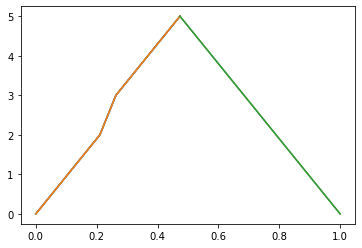

Estimated Dispersal Rate: [0.10526316]


In [204]:
sample_locs_array = np.array([0,1])

sigma = np.array([
    [2.5,2.5,2,2.5,0],
    [2.5,2.5,2,2.5,0],
    [2,2,2,2,0],
    [2.5,2.5,2,4.5,0],
    [0,0,0,0,5]
])

sigma_11 = sigma[0:sigma.shape[0]-2,0:sigma.shape[1]-2]
sigma_12 = sigma[0:sigma.shape[0]-2,sigma.shape[1]-2:sigma.shape[1]]
sigma_21 = sigma[sigma.shape[0]-2:sigma.shape[0],0:sigma.shape[1]-2]
sigma_22 = sigma[sigma.shape[0]-2:sigma.shape[0],sigma.shape[1]-2:sigma.shape[1]]
inv_sigma_22 = np.linalg.pinv(sigma_22)
dispersal_rate = estimate_mle_dispersal(inv_sigma_22, sample_locs_array)

u1 = locate_mle_gmrca(inv_sigma_22=inv_sigma_22, sample_locs=sample_locs_array)
cmvn_u = u1 + np.dot(np.dot(sigma_12, inv_sigma_22),sample_locs_array - u1)
cmvn_sigma = sigma_11 - np.dot(np.dot(sigma_12, inv_sigma_22), sigma_21)
node_times = ts.tables.nodes.time
node_locs = np.concatenate((sample_locs, np.transpose(cmvn_u), u1))

print("Bridges Method is plotted in color and Paths Method is plotted in grey!")

for p in paths:
    p_times = []
    p_locs = []
    for n in p:
        p_times.append(times[n])
        p_locs.append(locations[n])
    plt.plot(p_locs, p_times, color="grey")

for p in paths:
    p_times = []
    p_locs = []
    for n in p:
        p_times.append(node_times[n])
        p_locs.append(node_locs[n])
    plt.plot(p_locs, p_times)
plt.show()

print("Estimated Dispersal Rate:", dispersal_rate)

Methods overlay perfectly. The differences between estimated dispersal rates can be attributed to the k-1 factor (2 vs 1) in the denominator of the MLE calculation.

### Shared

TBD

## Two Loops

### Non-Intersecting

#### Two Unshared (Double Bubble)

In [205]:
tables = tskit.TableCollection(sequence_length=2e3)

node_table = tables.nodes
node_table.add_row(flags=tskit.NODE_IS_SAMPLE)  # Node 0
node_table.add_row(flags=tskit.NODE_IS_SAMPLE)  # Node 1
node_table.add_row(time=1, flags=msprime.NODE_IS_RE_EVENT)  # Node 2
node_table.add_row(time=1, flags=msprime.NODE_IS_RE_EVENT)  # Node 3
node_table.add_row(time=2, flags=msprime.NODE_IS_CA_EVENT)  # Node 4
node_table.add_row(time=3, flags=msprime.NODE_IS_RE_EVENT)  # Node 5
node_table.add_row(time=3, flags=msprime.NODE_IS_RE_EVENT)  # Node 6
node_table.add_row(time=4, flags=msprime.NODE_IS_CA_EVENT)  # Node 7
node_table.add_row(time=5)  # Node 8

edge_table = tables.edges
edge_table.add_row(left=0, right=500, parent=2, child=0)
edge_table.add_row(left=500, right=2e3, parent=3, child=0)
edge_table.add_row(left=0, right=500, parent=4, child=2)
edge_table.add_row(left=500, right=2e3, parent=4, child=3)
edge_table.add_row(left=0, right=1e3, parent=5, child=4)
edge_table.add_row(left=1e3, right=2e3, parent=6, child=4)
edge_table.add_row(left=0, right=1e3, parent=7, child=5)
edge_table.add_row(left=1e3, right=2e3, parent=7, child=6)
edge_table.add_row(left=0, right=2e3, parent=8, child=1)
edge_table.add_row(left=0, right=2e3, parent=8, child=7)

ts = tables.tree_sequence()

print(ts.draw_text())

5.00┊  8  ┊  8  ┊  8  ┊  
    ┊ ┏┻┓ ┊ ┏┻┓ ┊ ┏┻┓ ┊  
4.00┊ 7 ┃ ┊ 7 ┃ ┊ 7 ┃ ┊  
    ┊ ┃ ┃ ┊ ┃ ┃ ┊ ┃ ┃ ┊  
3.00┊ 5 ┃ ┊ 5 ┃ ┊ 6 ┃ ┊  
    ┊ ┃ ┃ ┊ ┃ ┃ ┊ ┃ ┃ ┊  
2.00┊ 4 ┃ ┊ 4 ┃ ┊ 4 ┃ ┊  
    ┊ ┃ ┃ ┊ ┃ ┃ ┊ ┃ ┃ ┊  
1.00┊ 2 ┃ ┊ 3 ┃ ┊ 3 ┃ ┊  
    ┊ ┃ ┃ ┊ ┃ ┃ ┊ ┃ ┃ ┊  
0.00┊ 0 1 ┊ 0 1 ┊ 0 1 ┊  
    0    500  1000  2000 



##### Paths

In [206]:
print("Number of Samples:", ts.num_samples)
print("Number of Trees:", ts.num_trees)

paths = identify_unique_paths(ts=ts)
print("Number of Paths:", len(paths))

sample_locs = np.linspace(0, 1, ts.num_samples) # evenly space the samples, ignore ordering of tree samples

times, locations, dispersal_rate = reconstruct_node_locations(
    ts=ts,
    paths=paths,
    sample_locs=sample_locs
)

print("Estimated Dispersal Rate:", dispersal_rate)

Number of Samples: 2
Number of Trees: 3
Number of Paths: 5
Estimated Dispersal Rate: [0.02777778]


##### Bridges

Bridges Method is plotted in color and Paths Method is plotted in grey!


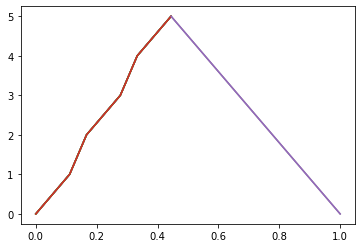

Estimated Dispersal Rate: [0.11111111]


In [207]:
sample_locs_array = np.array([0,1])

sigma = np.array([
    [3,3,2.5,1.5,1.5,1,3,0],
    [3,3,2.5,1.5,1.5,1,3,0],
    [2.5,2.5,2.5,1.5,1.5,1,2.5,0],
    [1.5,1.5,1.5,1.5,1.5,1,1.5,0],
    [1.5,1.5,1.5,1.5,1.5,1,1.5,0],
    [1,1,1,1,1,1,1,0],
    [3,3,2.5,1.5,1.5,1,4,0],
    [0,0,0,0,0,0,0,5]
])

sigma_11 = sigma[0:sigma.shape[0]-2,0:sigma.shape[1]-2]
sigma_12 = sigma[0:sigma.shape[0]-2,sigma.shape[1]-2:sigma.shape[1]]
sigma_21 = sigma[sigma.shape[0]-2:sigma.shape[0],0:sigma.shape[1]-2]
sigma_22 = sigma[sigma.shape[0]-2:sigma.shape[0],sigma.shape[1]-2:sigma.shape[1]]
inv_sigma_22 = np.linalg.pinv(sigma_22)
dispersal_rate = estimate_mle_dispersal(inv_sigma_22, sample_locs_array)

u1 = locate_mle_gmrca(inv_sigma_22=inv_sigma_22, sample_locs=sample_locs_array)
cmvn_u = u1 + np.dot(np.dot(sigma_12, inv_sigma_22),sample_locs_array - u1)
cmvn_sigma = sigma_11 - np.dot(np.dot(sigma_12, inv_sigma_22), sigma_21)
node_times = ts.tables.nodes.time
node_locs = np.concatenate((sample_locs, np.transpose(cmvn_u), u1))

print("Bridges Method is plotted in color and Paths Method is plotted in grey!")

for p in paths:
    p_times = []
    p_locs = []
    for n in p:
        p_times.append(times[n])
        p_locs.append(locations[n])
    plt.plot(p_locs, p_times, color="grey")

for p in paths:
    p_times = []
    p_locs = []
    for n in p:
        p_times.append(node_times[n])
        p_locs.append(node_locs[n])
    plt.plot(p_locs, p_times)
plt.show()

print("Estimated Dispersal Rate:", dispersal_rate)

Once again, methods overlay perfectly. The differences between estimated dispersal rates can be attributed to the k-1 factor (4 vs 1) in the denominator of the MLE calculation.

#### One Shared, One Unshared

TBD

### Intersecting

#### Nested Loops #1

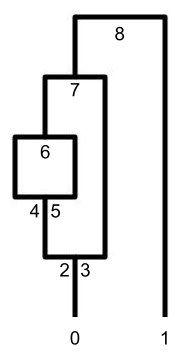

In [208]:
tables = tskit.TableCollection(sequence_length=2e3)

node_table = tables.nodes
node_table.add_row(flags=tskit.NODE_IS_SAMPLE)  # Node 0
node_table.add_row(flags=tskit.NODE_IS_SAMPLE)  # Node 1
node_table.add_row(time=1, flags=msprime.NODE_IS_RE_EVENT)  # Node 2
node_table.add_row(time=1, flags=msprime.NODE_IS_RE_EVENT)  # Node 3
node_table.add_row(time=2, flags=msprime.NODE_IS_RE_EVENT)  # Node 4
node_table.add_row(time=2, flags=msprime.NODE_IS_RE_EVENT)  # Node 5
node_table.add_row(time=3, flags=msprime.NODE_IS_CA_EVENT)  # Node 6
node_table.add_row(time=4, flags=msprime.NODE_IS_CA_EVENT)  # Node 7
node_table.add_row(time=5)  # Node 8

edge_table = tables.edges
edge_table.add_row(left=0, right=1500, parent=2, child=0)
edge_table.add_row(left=1500, right=2e3, parent=3, child=0)
edge_table.add_row(left=0, right=1e3, parent=4, child=2)
edge_table.add_row(left=1e3, right=1500, parent=5, child=2)
edge_table.add_row(left=0, right=1e3, parent=6, child=4)
edge_table.add_row(left=1e3, right=1500, parent=6, child=5)
edge_table.add_row(left=1500, right=2e3, parent=7, child=3)
edge_table.add_row(left=0, right=1500, parent=7, child=6)
edge_table.add_row(left=0, right=2e3, parent=8, child=1)
edge_table.add_row(left=0, right=2e3, parent=8, child=7)

ts = tables.tree_sequence()

print(ts.draw_text())

5.00┊  8  ┊  8  ┊  8  ┊  
    ┊ ┏┻┓ ┊ ┏┻┓ ┊ ┏┻┓ ┊  
4.00┊ 7 ┃ ┊ 7 ┃ ┊ 7 ┃ ┊  
    ┊ ┃ ┃ ┊ ┃ ┃ ┊ ┃ ┃ ┊  
3.00┊ 6 ┃ ┊ 6 ┃ ┊ ┃ ┃ ┊  
    ┊ ┃ ┃ ┊ ┃ ┃ ┊ ┃ ┃ ┊  
2.00┊ 4 ┃ ┊ 5 ┃ ┊ ┃ ┃ ┊  
    ┊ ┃ ┃ ┊ ┃ ┃ ┊ ┃ ┃ ┊  
1.00┊ 2 ┃ ┊ 2 ┃ ┊ 3 ┃ ┊  
    ┊ ┃ ┃ ┊ ┃ ┃ ┊ ┃ ┃ ┊  
0.00┊ 0 1 ┊ 0 1 ┊ 0 1 ┊  
    0   1000  1500  2000 



##### Paths

In [209]:
print("Number of Samples:", ts.num_samples)
print("Number of Trees:", ts.num_trees)

paths = identify_unique_paths(ts=ts)
print("Number of Paths:", len(paths))

sample_locs = np.linspace(0, 1, ts.num_samples) # evenly space the samples, ignore ordering of tree samples

times, locations, dispersal_rate = reconstruct_node_locations(
    ts=ts,
    paths=paths,
    sample_locs=sample_locs
)

print("Estimated Dispersal Rate:", dispersal_rate)

Number of Samples: 2
Number of Trees: 3
Number of Paths: 4
Estimated Dispersal Rate: [0.03985507]


##### Bridges

This is the simplest intersecting loops ARG that I could think of. What's nice is that we know that the loops that open and close before interacting with other paths (I've been referring to these as "bubbles") provide only half the variance of a single path of equivalent length. Using the standard Bridges Method, we can calculate a Brownian bridge through 7-6-4/5-2/3-7, and halve the distance between 6 and 4/5 to account for the smaller bubble in that region. This gives the variances for every node in the ARG; covariances at first seemed to work as well, but I found that the covariances between Node 0 (completely external to the loops) and Nodes 4/5 and 6 (completely internal to both loops) required a correction to account for reduced covariance (-1.5/5.5 in this example). I still don't know what this is, but when added, the Paths and Bridges Methods match exactly.

Bridges Method is plotted in color and Paths Method is plotted in grey!


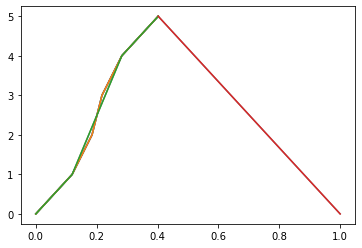

Estimated Dispersal Rate: [0.11956522]


In [210]:
sample_locs_array = np.array([0,1])

sigma = np.array([
    [1+7.5/5.5,1+7.5/5.5,1+6/5.5,1+6/5.5,1+4.5/5.5,1,1+7.5/5.5,0],
    [1+7.5/5.5,1+7.5/5.5,1,1,1,1,1+7.5/5.5,0],
    [1+6/5.5,1,1+6/5.5,1+6/5.5,1+4.5/5.5,1,1+(6-1.5)/5.5,0],
    [1+6/5.5,1,1+6/5.5,1+6/5.5,1+4.5/5.5,1,1+(6-1.5)/5.5,0],
    [1+4.5/5.5,1,1+4.5/5.5,1+4.5/5.5,1+4.5/5.5,1,1+(4.5-1.5)/5.5,0],
    [1,1,1,1,1,1,1,0],
    [1+7.5/5.5,1+7.5/5.5,1+(6-1.5)/5.5,1+(6-1.5)/5.5,1+(4.5-1.5)/5.5,1,2+7.5/5.5,0],
    [0,0,0,0,0,0,0,5]
])

sigma_11 = sigma[0:sigma.shape[0]-2,0:sigma.shape[1]-2]
sigma_12 = sigma[0:sigma.shape[0]-2,sigma.shape[1]-2:sigma.shape[1]]
sigma_21 = sigma[sigma.shape[0]-2:sigma.shape[0],0:sigma.shape[1]-2]
sigma_22 = sigma[sigma.shape[0]-2:sigma.shape[0],sigma.shape[1]-2:sigma.shape[1]]
inv_sigma_22 = np.linalg.pinv(sigma_22)
dispersal_rate = estimate_mle_dispersal(inv_sigma_22, sample_locs_array)

u1 = locate_mle_gmrca(inv_sigma_22=inv_sigma_22, sample_locs=sample_locs_array)
cmvn_u = u1 + np.dot(np.dot(sigma_12, inv_sigma_22),sample_locs_array - u1)
cmvn_sigma = sigma_11 - np.dot(np.dot(sigma_12, inv_sigma_22), sigma_21)
node_times = ts.tables.nodes.time
node_locs = np.concatenate((sample_locs, np.transpose(cmvn_u), u1))

print("Bridges Method is plotted in color and Paths Method is plotted in grey!")

for p in paths:
    p_times = []
    p_locs = []
    for n in p:
        p_times.append(times[n])
        p_locs.append(locations[n])
    plt.plot(p_locs, p_times, color="grey")

for p in paths:
    p_times = []
    p_locs = []
    for n in p:
        p_times.append(node_times[n])
        p_locs.append(node_locs[n])
    plt.plot(p_locs, p_times)
plt.show()

print("Estimated Dispersal Rate:", dispersal_rate)

#### Nested Loops #2

In [211]:
tables = tskit.TableCollection(sequence_length=2e3)

node_table = tables.nodes
node_table.add_row(flags=tskit.NODE_IS_SAMPLE)  # Node 0
node_table.add_row(flags=tskit.NODE_IS_SAMPLE)  # Node 1
node_table.add_row(time=1, flags=msprime.NODE_IS_RE_EVENT)  # Node 2
node_table.add_row(time=1, flags=msprime.NODE_IS_RE_EVENT)  # Node 3
node_table.add_row(time=2, flags=msprime.NODE_IS_RE_EVENT)  # Node 4
node_table.add_row(time=2, flags=msprime.NODE_IS_RE_EVENT)  # Node 5
node_table.add_row(time=3, flags=msprime.NODE_IS_CA_EVENT)  # Node 6
node_table.add_row(time=5, flags=msprime.NODE_IS_CA_EVENT)  # Node 7
node_table.add_row(time=6)  # Node 8

edge_table = tables.edges
edge_table.add_row(left=0, right=1500, parent=2, child=0)
edge_table.add_row(left=1500, right=2e3, parent=3, child=0)
edge_table.add_row(left=0, right=1e3, parent=4, child=2)
edge_table.add_row(left=1e3, right=1500, parent=5, child=2)
edge_table.add_row(left=0, right=1e3, parent=6, child=4)
edge_table.add_row(left=1e3, right=1500, parent=6, child=5)
edge_table.add_row(left=1500, right=2e3, parent=7, child=3)
edge_table.add_row(left=0, right=1500, parent=7, child=6)
edge_table.add_row(left=0, right=2e3, parent=8, child=1)
edge_table.add_row(left=0, right=2e3, parent=8, child=7)

ts = tables.tree_sequence()

print(ts.draw_text())

6.00┊  8  ┊  8  ┊  8  ┊  
    ┊ ┏┻┓ ┊ ┏┻┓ ┊ ┏┻┓ ┊  
5.00┊ 7 ┃ ┊ 7 ┃ ┊ 7 ┃ ┊  
    ┊ ┃ ┃ ┊ ┃ ┃ ┊ ┃ ┃ ┊  
3.00┊ 6 ┃ ┊ 6 ┃ ┊ ┃ ┃ ┊  
    ┊ ┃ ┃ ┊ ┃ ┃ ┊ ┃ ┃ ┊  
2.00┊ 4 ┃ ┊ 5 ┃ ┊ ┃ ┃ ┊  
    ┊ ┃ ┃ ┊ ┃ ┃ ┊ ┃ ┃ ┊  
1.00┊ 2 ┃ ┊ 2 ┃ ┊ 3 ┃ ┊  
    ┊ ┃ ┃ ┊ ┃ ┃ ┊ ┃ ┃ ┊  
0.00┊ 0 1 ┊ 0 1 ┊ 0 1 ┊  
    0   1000  1500  2000 



##### Paths

In [212]:
print("Number of Samples:", ts.num_samples)
print("Number of Trees:", ts.num_trees)

paths = identify_unique_paths(ts=ts)
print("Number of Paths:", len(paths))

sample_locs = np.linspace(0, 1, ts.num_samples) # evenly space the samples, ignore ordering of tree samples

times, locations, dispersal_rate = reconstruct_node_locations(
    ts=ts,
    paths=paths,
    sample_locs=sample_locs
)

print("Estimated Dispersal Rate:", dispersal_rate)

Number of Samples: 2
Number of Trees: 3
Number of Paths: 4
Estimated Dispersal Rate: [0.03378378]


##### Bridges

Note that as the larger loop has grown in size, the correction factor for the covariances between Node 0 and Nodes 4/5 and 6 has increased to -2.5/5.5 and -3/5.5, respectively.

Bridges Method is plotted in color and Paths Method is plotted in grey!


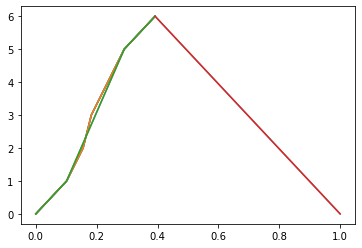

Estimated Dispersal Rate: [0.10135135]


In [213]:
sample_locs_array = np.array([0,1])

sigma = np.array([
    [1+14/7.5,1+14/7.5,1+12.5/7.5,1+12.5/7.5,1+11/7.5,1,1+14/7.5,0],
    [1+14/7.5,1+14/7.5,1,1,1,1,1+14/7.5,0],
    [1+12.5/7.5,1,1+12.5/7.5,1+12.5/7.5,1+11/7.5,1,1+(12.5-2.5)/7.5,0],
    [1+12.5/7.5,1,1+12.5/7.5,1+12.5/7.5,1+11/7.5,1,1+(12.5-2.5)/7.5,0],
    [1+11/7.5,1,1+11/7.5,1+11/7.5,1+11/7.5,1,1+(11-3)/7.5,0],
    [1,1,1,1,1,1,1,0],
    [1+14/7.5,1+14/7.5,1+(12.5-2.5)/7.5,1+(12.5-2.5)/7.5,1+(11-3)/7.5,1,2+14/7.5,0],
    [0,0,0,0,0,0,0,6]
])

sigma_11 = sigma[0:sigma.shape[0]-2,0:sigma.shape[1]-2]
sigma_12 = sigma[0:sigma.shape[0]-2,sigma.shape[1]-2:sigma.shape[1]]
sigma_21 = sigma[sigma.shape[0]-2:sigma.shape[0],0:sigma.shape[1]-2]
sigma_22 = sigma[sigma.shape[0]-2:sigma.shape[0],sigma.shape[1]-2:sigma.shape[1]]
inv_sigma_22 = np.linalg.pinv(sigma_22)
dispersal_rate = estimate_mle_dispersal(inv_sigma_22, sample_locs_array)

u1 = locate_mle_gmrca(inv_sigma_22=inv_sigma_22, sample_locs=sample_locs_array)
cmvn_u = u1 + np.dot(np.dot(sigma_12, inv_sigma_22),sample_locs_array - u1)
cmvn_sigma = sigma_11 - np.dot(np.dot(sigma_12, inv_sigma_22), sigma_21)
node_times = ts.tables.nodes.time
node_locs = np.concatenate((sample_locs, np.transpose(cmvn_u), u1))

print("Bridges Method is plotted in color and Paths Method is plotted in grey!")

for p in paths:
    p_times = []
    p_locs = []
    for n in p:
        p_times.append(times[n])
        p_locs.append(locations[n])
    plt.plot(p_locs, p_times, color="grey")

for p in paths:
    p_times = []
    p_locs = []
    for n in p:
        p_times.append(node_times[n])
        p_locs.append(node_locs[n])
    plt.plot(p_locs, p_times)
plt.show()

print("Estimated Dispersal Rate:", dispersal_rate)

#### Nested Loops #3

In [214]:
tables = tskit.TableCollection(sequence_length=2e3)

node_table = tables.nodes
node_table.add_row(flags=tskit.NODE_IS_SAMPLE)  # Node 0
node_table.add_row(flags=tskit.NODE_IS_SAMPLE)  # Node 1
node_table.add_row(time=1, flags=msprime.NODE_IS_RE_EVENT)  # Node 2
node_table.add_row(time=1, flags=msprime.NODE_IS_RE_EVENT)  # Node 3
node_table.add_row(time=2, flags=msprime.NODE_IS_RE_EVENT)  # Node 4
node_table.add_row(time=2, flags=msprime.NODE_IS_RE_EVENT)  # Node 5
node_table.add_row(time=3, flags=msprime.NODE_IS_CA_EVENT)  # Node 6
node_table.add_row(time=4, flags=msprime.NODE_IS_CA_EVENT)  # Node 7
node_table.add_row(time=5)  # Node 8

edge_table = tables.edges
edge_table.add_row(left=0, right=1e3, parent=2, child=0)
edge_table.add_row(left=1e3, right=2e3, parent=3, child=0)
edge_table.add_row(left=0, right=500, parent=4, child=2)
edge_table.add_row(left=500, right=1e3, parent=5, child=2)
edge_table.add_row(left=1e3, right=2e3, parent=6, child=3)
edge_table.add_row(left=500, right=1e3, parent=6, child=5)
edge_table.add_row(left=0, right=500, parent=7, child=4)
edge_table.add_row(left=500, right=2e3, parent=7, child=6)
edge_table.add_row(left=0, right=2e3, parent=8, child=1)
edge_table.add_row(left=0, right=2e3, parent=8, child=7)

ts = tables.tree_sequence()

print(ts.draw_text())

5.00┊  8  ┊  8  ┊  8  ┊  
    ┊ ┏┻┓ ┊ ┏┻┓ ┊ ┏┻┓ ┊  
4.00┊ 7 ┃ ┊ 7 ┃ ┊ 7 ┃ ┊  
    ┊ ┃ ┃ ┊ ┃ ┃ ┊ ┃ ┃ ┊  
3.00┊ ┃ ┃ ┊ 6 ┃ ┊ 6 ┃ ┊  
    ┊ ┃ ┃ ┊ ┃ ┃ ┊ ┃ ┃ ┊  
2.00┊ 4 ┃ ┊ 5 ┃ ┊ ┃ ┃ ┊  
    ┊ ┃ ┃ ┊ ┃ ┃ ┊ ┃ ┃ ┊  
1.00┊ 2 ┃ ┊ 2 ┃ ┊ 3 ┃ ┊  
    ┊ ┃ ┃ ┊ ┃ ┃ ┊ ┃ ┃ ┊  
0.00┊ 0 1 ┊ 0 1 ┊ 0 1 ┊  
    0    500  1000  2000 



##### Paths

In [215]:
print("Number of Samples:", ts.num_samples)
print("Number of Trees:", ts.num_trees)

paths = identify_unique_paths(ts=ts)
print("Number of Paths:", len(paths))

sample_locs = np.linspace(0, 1, ts.num_samples) # evenly space the samples, ignore ordering of tree samples

times, locations, dispersal_rate = reconstruct_node_locations(
    ts=ts,
    paths=paths,
    sample_locs=sample_locs
)

print("Estimated Dispersal Rate:", dispersal_rate)

Number of Samples: 2
Number of Trees: 3
Number of Paths: 4
Estimated Dispersal Rate: [0.03968254]


##### Bridges

In [216]:
sample_locs_array = np.array([0,1])
sigma_22 = np.array([[2+4.5/4.25,0],[0,5]])
inv_sigma_22 = np.linalg.pinv(sigma_22)
print("Estimated Dispersal Rate:", estimate_mle_dispersal(inv_sigma_22, sample_locs_array))

Estimated Dispersal Rate: [0.12408759]


This is completely different than the estimated dispersal rate using the Paths Method, so I don't think that I properly calculated the sample variances. My guess is the correction factors are playing a much more intricate role in this scenario.